# TP : Convolutional Neural Network

# Import

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%load_ext autotime



The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2025-06-15 14:28:10 +02:00)


# Donwload the dataset

In [10]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True,transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=False,transform=transform)

100%|██████████| 26.4M/26.4M [00:07<00:00, 3.52MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.23MB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.00MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.17MB/s]

time: 9.89 s (started: 2025-06-15 14:28:17 +02:00)


In [11]:
nb_image,h,w=np.shape(train_dataset.data)
nb_image,h,w

(60000, 28, 28)

time: 0 ns (started: 2025-06-15 14:28:27 +02:00)


# CNN

Define the CNN model

In [12]:
# Set device we use for computation (cpu or gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CNN(nn.Module):
    def __init__(self,filter_size = 3,im_size = 28,n_channels = 1,n_start_filters = 32):
        super(CNN, self).__init__()

        self.filter_size = filter_size
        self.im_size = im_size
        self.n_channels = n_channels
        self.n_start_filters = n_start_filters
        #Create the Convolutional part of the CNN
        self.Conv= nn.Sequential(

        nn.Conv2d(in_channels=self.n_channels,out_channels=self.n_start_filters,kernel_size=self.filter_size, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=self.n_start_filters,out_channels=self.n_start_filters*2 ,kernel_size=self.filter_size, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Flatten())

        #I pass a empty tensor to my CNN to get the output dimension
        n_feature= self.Conv(torch.empty(1,1, self.im_size, self.im_size)).size(-1)


        #Create the Dense part of the CNN
        self.DNN = nn.Sequential(
            nn.Linear(n_feature, 128),
            nn.ReLU(),
            nn.Linear(128,10),
            nn.ReLU()
        )
    #define how to assemble all the previous layers
    def forward(self, x):
        x=self.Conv(x)
        x=self.DNN(x)
        return x


time: 1.19 s (started: 2025-06-15 14:28:27 +02:00)


# Analyzing the Impact of Batch Size on Accuracy and Processing Speed

Let's investigate the relationship between batch size, execution time, and accuracy by evaluating accuracy and processing speed (images per unit time) at various batch sizes


In [15]:
# Parameter
batch_save=[]
acc=[]
imgpersec_save=[]
for p in tqdm(range(4,11)):
    # Parameter
    batch_size=2**p
    num_epochs = 5
    lr=0.001
    # Data loader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    nb_image=len(test_loader.dataset)+len(train_loader.dataset)
    size_test=len(test_loader.dataset)
    # Initialize the model, loss function, and optimizer
    model = CNN(filter_size = 3,im_size = h,n_channels = 1,n_start_filters = 32).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training the model
    timer=[]
    for epoch in range(num_epochs):
        start = time.time()

        #train
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            #Forward pass
            outputs = model(images)
            #Compute error
            loss = criterion(outputs, labels)
            #Set gradient to zero
            optimizer.zero_grad()
            #Comptute gradient with Backward pass
            loss.backward()
            #Optimize the neural network
            optimizer.step()
        end = time.time()
        timer.append([end - start])

        #test
        with torch.inference_mode():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
        accuracy=correct/size_test
    acc.append(accuracy)
    img_per_seconds=nb_image/np.mean(timer)
    imgpersec_save.append(img_per_seconds)
    batch_save.append(str(batch_size))

100%|██████████| 7/7 [03:20<00:00, 28.67s/it]

time: 3min 20s (started: 2025-06-15 14:33:18 +02:00)


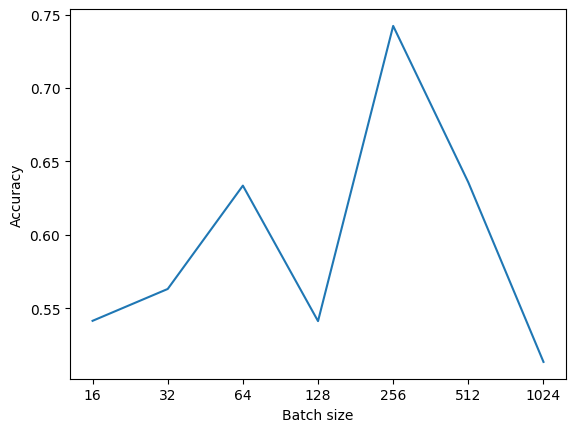

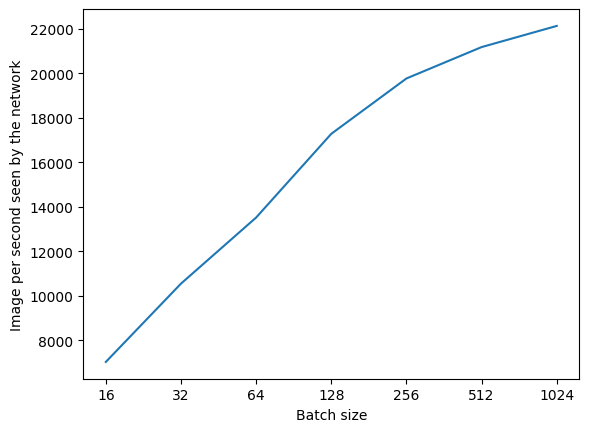

time: 109 ms (started: 2025-06-15 14:36:39 +02:00)


In [16]:
plt.plot(batch_save,acc)
plt.ylabel('Accuracy')
plt.xlabel('Batch size')
plt.show()
plt.plot(batch_save,imgpersec_save)
plt.xlabel('Batch size')
plt.ylabel('Image per second seen by the network')
plt.show()

# Conclusion
While increasing the batch size typically speeds up computation and improves hardware utilization, exceeding a certain threshold may harm model accuracy because of decreased gradient diversity and possible overfitting to batch-specific patterns.